## Capstone Project – The Battle of Neighborhoods | Finding a Better Place in Scarborough, Toronto

### 1. Installing and Importing Python Libraries and Dependencies

In [1]:
!pip install geocoder
!pip install folium
import pandas as pd
import requests
import numpy as np
import geocoder
import folium
import requests 
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
import xml
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from pandas.io.json import json_normalize 
from sklearn.cluster import KMeans
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim
!conda install -c conda-forge bs4 --yes
from bs4 import BeautifulSoup
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
print("All Required Libraries Imported!")

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.1
  latest version: 4.10.2

Please update conda by running

    $ conda update -n base conda



# All requested packages already installed.

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.1
  latest version: 4.10.2

Please update conda by running

    $ conda update -n base conda



# All requested packages already installed.

All Required Libraries Imported!


### 2. Data Extraction and Cleaning

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
r=requests.get(url)
toronto_list= pd.read_html(r.text)
toronto=toronto_list[0]
print("Shape of data frame:", toronto.shape)
toronto.head()

Shape of data frame: (20, 9)


,0,1,2,3,4,5,6,7,8
0,M1ANot assigned,M2ANot assigned,M3ANorth York(Parkwoods),M4ANorth York(Victoria Village),M5ADowntown Toronto(Regent Park / Harbourfront),M6ANorth York(Lawrence Manor / Lawrence Heights),M7AQueen's Park(Ontario Provincial Government),M8ANot assigned,M9AEtobicoke(Islington Avenue)
1,M1BScarborough(Malvern / Rouge),M2BNot assigned,M3BNorth York(Don Mills)North,M4BEast York(Parkview Hill / Woodbine Gardens),"M5BDowntown Toronto(Garden District, Ryerson)",M6BNorth York(Glencairn),M7BNot assigned,M8BNot assigned,M9BEtobicoke(West Deane Park / Princess Garden...
2,M1CScarborough(Rouge Hill / Port Union / Highl...,M2CNot assigned,M3CNorth York(Don Mills)South(Flemingdon Park),M4CEast York(Woodbine Heights),M5CDowntown Toronto(St. James Town),M6CYork(Humewood-Cedarvale),M7CNot assigned,M8CNot assigned,M9CEtobicoke(Eringate / Bloordale Gardens / Ol...
3,M1EScarborough(Guildwood / Morningside / West ...,M2ENot assigned,M3ENot assigned,M4EEast Toronto(The Beaches),M5EDowntown Toronto(Berczy Park),M6EYork(Caledonia-Fairbanks),M7ENot assigned,M8ENot assigned,M9ENot assigned
4,M1GScarborough(Woburn),M2GNot assigned,M3GNot assigned,M4GEast York(Leaside),M5GDowntown Toronto(Central Bay Street),M6GDowntown Toronto(Christie),M7GNot assigned,M8GNot assigned,M9GNot assigned


In [3]:
# Iterating through every column and row from the toronto dataframe then appending all the values to an empty list and transforming the list into a dataframe with a single column
Zlist=[]
cols=list(toronto)
for k, row in toronto.iterrows():
    for j in cols:
        colsObject=toronto[j][k]
        Zlist.append(colsObject)
dfToronto=pd.DataFrame(Zlist)
# Removing the rows with "Not assigned" boroughs and renaming the only column
dfToronto=dfToronto[~dfToronto[0].str.contains("Not assigned")]
dfToronto=dfToronto.reset_index(drop=True)
dfToronto=dfToronto.rename(columns={ 0:'Information'})
# Iterating through the rows of the Toronto dataframe, then creating a list with the first 3 characters of the string in the "Information" column, transforming the list to a dataframe and assigning the values to a new column of the dfToronto called "PostalCode"
Klist=[]
for k, row in dfToronto.iterrows():
        colsObject=row['Information'][:3]
        Klist.append(colsObject)
result1=pd.DataFrame(Klist)
dfToronto["PostalCode"]=result1
# Iterating through the rows of the Toronto dataframe again, then creating a list with beginning at the 4th character of the string in the "Information" column, transforming the list to a dataframe and assigning the values to a new column #of the dfToronto called "Hood"
Wlist=[]
for k, row in dfToronto.iterrows():
        colsObject=row['Information'][3:]
        Wlist.append(colsObject)
result2=pd.DataFrame(Wlist)
dfToronto["Hood"]=result2
# Splitting the string in the "Hood" column based on the "(" character to two other columns named "Borough" and "Neighborhood". 
# The part before the bracket will be in the "Borough" column and then in the "Neighborhood" column the ")" character was removed
dfToronto[['Borough','Neighborhood']]=dfToronto.Hood.str.split("(",1,expand=True)
dfToronto['Neighborhood']=dfToronto['Neighborhood'].str.replace(')','')
dfToronto['Neighborhood']=dfToronto['Neighborhood'].str.replace(' /',',')
# Replacing the name of some of the boroughs
dfToronto['Borough']=dfToronto['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                     'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                     'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                     'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})
# Removing columns that are not needed
dfToronto.drop(['Information', 'Hood'], axis='columns', inplace=True)
dfToronto.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


In [4]:
dfToronto.describe()

,PostalCode,Borough,Neighborhood
count,103,103,103
unique,103,15,103
top,M4G,North York,Roselawn
freq,1,24,1


In [5]:
print("Shape of the dataframe:", dfToronto.shape)

Shape of the dataframe: (103, 3)


In [6]:
postal_code = dfToronto['PostalCode']

# Empty lists that will store the coordinates information from the geocoder
latitude = []
longitude = []
n = 0

# Loop that keeps on trying to get the latitude and longitude for each neighborhood until it succeedes
while n < len(postal_code):
    g = geocoder.arcgis('{}, Toronto, Ontario'.format(postal_code[n]))
    lat_lng_coords = g.latlng
    print('The geograpical coordinate of {} are {}, {}.'.format(postal_code[n], lat_lng_coords[0], lat_lng_coords[1]))
    latitude.append(lat_lng_coords[0])
    longitude.append(lat_lng_coords[1])
    n = n + 1

dfToronto['Longitude'] = longitude
dfToronto['Latitude'] = latitude
dfToronto.head()

The geograpical coordinate of M3A are 43.75245000000007, -79.32990999999998.
The geograpical coordinate of M4A are 43.73057000000006, -79.31305999999995.
The geograpical coordinate of M5A are 43.65512000000007, -79.36263999999994.
The geograpical coordinate of M6A are 43.72327000000007, -79.45041999999995.
The geograpical coordinate of M7A are 43.66253000000006, -79.39187999999996.
The geograpical coordinate of M9A are 43.662630000000036, -79.52830999999998.
The geograpical coordinate of M1B are 43.811390000000074, -79.19661999999994.
The geograpical coordinate of M3B are 43.74923000000007, -79.36185999999998.
The geograpical coordinate of M4B are 43.70718000000005, -79.31191999999999.
The geograpical coordinate of M5B are 43.65739000000008, -79.37803999999994.
The geograpical coordinate of M6B are 43.70687000000004, -79.44811999999996.
The geograpical coordinate of M9B are 43.65034000000003, -79.55361999999997.
The geograpical coordinate of M1C are 43.78574000000003, -79.1587499999999

,PostalCode,Borough,Neighborhood,Longitude,Latitude
0,M3A,North York,Parkwoods,-79.32991,43.75245
1,M4A,North York,Victoria Village,-79.31306,43.73057
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",-79.36264,43.65512
3,M6A,North York,"Lawrence Manor, Lawrence Heights",-79.45042,43.72327
4,M7A,Queen's Park,Ontario Provincial Government,-79.39188,43.66253


In [7]:
# Saving the dataframe to a CSV
dfToronto.to_csv("TorontoDfWithCoordinates")

In [8]:
address = 'Scarborough,Toronto'

geolocator = Nominatim(user_agent="yyz_explorer")
location = geolocator.geocode(address)
latitude_x = location.latitude
longitude_y = location.longitude
print('The Geograpical Co-ordinate of Scarborough,Toronto are {}, {}.'.format(latitude_x, longitude_y))

The Geograpical Co-ordinate of Scarborough,Toronto are 43.7729744, -79.2576479.


### 3. Map of Scarborough

In [9]:
map_Scarborough = folium.Map(location=[latitude_x, longitude_y], zoom_start=10)

for lat, lng, nei in zip(dfToronto['Latitude'], dfToronto['Longitude'], dfToronto['Neighborhood']):
    
    label = '{}'.format(nei)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Scarborough)  
    
map_Scarborough

In [10]:
address = 'Scarborough,Toronto'

geolocator = Nominatim(user_agent="yyz_explorer")
location = geolocator.geocode(address)
latitude_n1 = location.latitude
longitude_n1 = location.longitude
print('The Geograpical Co-ordinate of Neighborhood_1 are {}, {}.'.format(latitude_x, longitude_y))

The Geograpical Co-ordinate of Neighborhood_1 are 43.7729744, -79.2576479.


In [20]:
# @hiddel_cell
CLIENT_ID = 'WTPIU3WM1BL1XL0MERWKQ15CQTNFQYPPEEMQPW1YTTFWIBDK' # my Foursquare ID
CLIENT_SECRET = 'SLJR14HZIUZB1I5UHOORMNCAROULID5IFIDN2JLX0VYWXJS2' # my Foursquare Secret
VERSION = '20180605'
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: '+CLIENT_ID)
print('CLIENT_SECRET: '+CLIENT_SECRET)

Your credentails:
CLIENT_ID: WTPIU3WM1BL1XL0MERWKQ15CQTNFQYPPEEMQPW1YTTFWIBDK
CLIENT_SECRET: SLJR14HZIUZB1I5UHOORMNCAROULID5IFIDN2JLX0VYWXJS2


In [21]:
radius = 700 
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude_n1, 
   longitude_n1, 
    radius, 
   LIMIT)
results = requests.get(url).json()

In [22]:
venues=results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.columns

Index(['referralId', 'reasons.count', 'reasons.items', 'venue.id',
       'venue.name', 'venue.location.address', 'venue.location.crossStreet',
       'venue.location.lat', 'venue.location.lng',
       'venue.location.labeledLatLngs', 'venue.location.distance',
       'venue.location.postalCode', 'venue.location.cc', 'venue.location.city',
       'venue.location.state', 'venue.location.country',
       'venue.location.formattedAddress', 'venue.categories',
       'venue.photos.count', 'venue.photos.groups',
       'venue.location.neighborhood', 'venue.venuePage.id'],
      dtype='object')

In [23]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

### 4. Nearby Venues/Locations

In [24]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Hot Topic,"[{'id': '4bf58dd8d48988d103951735', 'name': 'C...",43.775450,-79.257929
1,Tommy Hilfiger,"[{'id': '4bf58dd8d48988d103951735', 'name': 'C...",43.776015,-79.257369
2,New York Fries - Scarborough TC,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",43.775135,-79.256858
3,lululemon athletica,"[{'id': '4bf58dd8d48988d103951735', 'name': 'C...",43.775517,-79.258423
4,Subway,"[{'id': '4bf58dd8d48988d1c5941735', 'name': 'S...",43.775102,-79.257115


### 5. Categories of Nearby Venues/Locations

In [25]:

nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(100)

,name,categories,lat,lng
0,Hot Topic,Clothing Store,43.775450,-79.257929
1,Tommy Hilfiger,Clothing Store,43.776015,-79.257369
2,New York Fries - Scarborough TC,Restaurant,43.775135,-79.256858
3,lululemon athletica,Clothing Store,43.775517,-79.258423
4,Subway,Sandwich Place,43.775102,-79.257115
5,Subway,Sandwich Place,43.771477,-79.252805
6,St. Andrews Fish & Chips,Fish & Chips Shop,43.771865,-79.252645
7,Petro-Canada,Gas Station,43.769724,-79.261677
8,Disney Store,Toy / Game Store,43.775537,-79.256833
9,Scaddabush Italian Kitchen & Bar,Italian Restaurant,43.777460,-79.254358


In [26]:
# Top 10 Categories
a=pd.Series(nearby_venues.categories)
a.value_counts()[:10]

Restaurant            5
Clothing Store        4
Coffee Shop           3
Pharmacy              2
Sandwich Place        2
Shoe Store            2
Department Store      2
Gas Station           2
Fish & Chips Shop     1
Chinese Restaurant    1
Name: categories, dtype: int64

In [27]:
def getNearbyVenues(names, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # making GET request
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [28]:
Scarborough_venues = getNearbyVenues(names=dfToronto['Neighborhood'],
                                   latitudes=dfToronto['Latitude'],
                                   longitudes=dfToronto['Longitude']
                                  )

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Ontario Provincial Government
Islington Avenue
Malvern, Rouge
Don MillsNorth
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don MillsSouth(Flemingdon Park
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
The Danforth East
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmount Park
Bayview Village
DownsviewEast 

In [29]:
print('There are {} Uniques Categories.'.format(len(Scarborough_venues['Venue Category'].unique())))
Scarborough_venues.groupby('Neighborhood').count().head()

There are 289 Uniques Categories.


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,20,20,20,20,20,20
"Alderwood, Long Branch",5,5,5,5,5,5
"Bathurst Manor, Wilson Heights, Downsview North",9,9,9,9,9,9
Bayview Village,6,6,6,6,6,6
"Bedford Park, Lawrence Manor East",26,26,26,26,26,26


In [30]:
# one hot encoding
Scarborough_onehot = pd.get_dummies(Scarborough_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Scarborough_onehot['Neighborhood'] = Scarborough_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Scarborough_onehot.columns[-1]] + list(Scarborough_onehot.columns[:-1])
Scarborough_onehot = Scarborough_onehot[fixed_columns]
Scarborough_grouped = Scarborough_onehot.groupby('Neighborhood').mean().reset_index()
Scarborough_onehot.head(5)

,Zoo Exhibit,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Stadium,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hakka Restaurant,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Paper / Office Supplies Store,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Road,Rock Climbing Spot,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Social Club,Soup Place,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stationery Store,Steakhouse,Storage Facility,Street Art,Strip Club,Supermarket,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Tram Station,Turkish Restaurant,University,Vegetaria

In [31]:
num_top_venues = 5
for hood in Scarborough_grouped['Neighborhood']:
    print("---- "+hood+" ----")
    temp =Scarborough_grouped[Scarborough_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- Agincourt ----
                venue  freq
0       Shopping Mall  0.10
1         Supermarket  0.10
2  Chinese Restaurant  0.10
3                Pool  0.05
4         Coffee Shop  0.05


---- Alderwood, Long Branch ----
            venue  freq
0     Gas Station   0.2
1             Pub   0.2
2     Coffee Shop   0.2
3  Sandwich Place   0.2
4     Pizza Place   0.2


---- Bathurst Manor, Wilson Heights, Downsview North ----
               venue  freq
0        Coffee Shop  0.22
1        Pizza Place  0.22
2       Intersection  0.11
3               Park  0.11
4  Convenience Store  0.11


---- Bayview Village ----
         venue  freq
0      Dog Run  0.17
1  Flower Shop  0.17
2  Gas Station  0.17
3        Trail  0.17
4         Park  0.17


---- Bedford Park, Lawrence Manor East ----
            venue  freq
0  Sandwich Place  0.08
1     Coffee Shop  0.08
2      Restaurant  0.08
3             Pub  0.04
4   Grocery Store  0.04


---- Berczy Park ----
                 venue  freq
0          Cof

In [32]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Most common venues near neighborhoods

In [33]:
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Scarborough_grouped['Neighborhood']

for ind in np.arange(Scarborough_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Scarborough_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Chinese Restaurant,Shopping Mall,Supermarket,Pool,Bakery,Pizza Place,Coffee Shop,Clothing Store,Print Shop,Sandwich Place
1,"Alderwood, Long Branch",Gas Station,Coffee Shop,Pub,Sandwich Place,Pizza Place,Dog Run,Dim Sum Restaurant,Diner,Discount Store,Distribution Center
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Pizza Place,Sushi Restaurant,Intersection,Sandwich Place,Convenience Store,Park,Yoga Studio,Doner Restaurant,Discount Store
3,Bayview Village,Asian Restaurant,Flower Shop,Trail,Dog Run,Park,Gas Station,Yoga Studio,Doner Restaurant,Discount Store,Distribution Center
4,"Bedford Park, Lawrence Manor East",Coffee Shop,Restaurant,Sandwich Place,Liquor Store,Intersection,Italian Restaurant,Japanese Restaurant,Sushi Restaurant,Juice Bar,Sports Club


### K-Means Clustering Approach

In [34]:
Scarborough_grouped_clustering = Scarborough_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=3, random_state=0).fit(Scarborough_grouped_clustering)
kmeans.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0], dtype=int32)

In [35]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Scarborough_merged =dfToronto.iloc[:16,:]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Scarborough_merged = Scarborough_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Scarborough_merged.head()
# see last columns!

,PostalCode,Borough,Neighborhood,Longitude,Latitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,-79.32991,43.75245,0,Fast Food Restaurant,Bed & Breakfast,Park,Food & Drink Shop,Pet Store,Escape Room,Elementary School,Electronics Store,Eastern European Restaurant,Diner
1,M4A,North York,Victoria Village,-79.31306,43.73057,1,Portuguese Restaurant,Middle Eastern Restaurant,Coffee Shop,Intersection,Pizza Place,Yoga Studio,Donut Shop,Discount Store,Distribution Center,Dive Bar
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",-79.36264,43.65512,1,Coffee Shop,Café,Restaurant,Park,Pub,Bakery,Italian Restaurant,Thai Restaurant,Sushi Restaurant,Performing Arts Venue
3,M6A,North York,"Lawrence Manor, Lawrence Heights",-79.45042,43.72327,1,Clothing Store,Fast Food Restaurant,Restaurant,Furniture / Home Store,Dessert Shop,Sushi Restaurant,Shoe Store,Fried Chicken Joint,Bookstore,Toy / Game Store
4,M7A,Queen's Park,Ontario Provincial Government,-79.39188,43.66253,1,Coffee Shop,Burrito Place,Sandwich Place,Sushi Restaurant,Café,Park,Yoga Studio,Burger Joint,Salon / Barbershop,Pub


### Map of clusters

In [36]:
kclusters = 10

In [37]:
# create map
map_clusters = folium.Map(location=[latitude_x, longitude_y], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)
# add markers to the map

markers_colors = []
for lat, lon, nei , cluster in zip(Scarborough_merged['Latitude'], 
                                   Scarborough_merged['Longitude'], 
                                   Scarborough_merged['Neighborhood'], 
                                   Scarborough_merged['Cluster Labels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

['#8000ff', '#4856fb', '#10a2f0', '#2adddd', '#62fbc4', '#9cfba4', '#d4dd80', '#ffa256', '#ff562c', '#ff0000']


In [38]:
df1=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 0,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]
df2=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 1,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]
df3=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 2,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]

In [40]:
Scarborough_Avg_HousingPrice=pd.DataFrame({"Neighborhood":dfToronto["Neighborhood"],
                                      "Average_Housing_Price":[335000.0,286600.0,175000.0,225900.0,219400.0,
                                                               573900.0,225000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,225000.0,370500.,255400.0,433500.0,433500.0,
                                                               435000.0,289500.0,265000.0,285900.0,239400.0,
                                                               589900.0,295000.0,380500.0,378500.0,438500.0,229200.0,
                                                               229200.0,365000.0,388500.,285400.0,493500.0,477500.0,378000.0,316600.0,195000.0,225900.0,219400.0,
                                                               573900.0,367000.0,370500.0,370500.0,363500.0,279200.0,
                                                               279200.0,271000.0,370500.,255400.0,383500.0,433500.0,335000.0,286600.0,185000.0,225900.0,219400.0,
                                                               573900.0,329000.0,370500.0,370500.0,533500.0,279200.0,
                                                               279200.0,375000.0,370500.,255400.0,493500.0,433500.0,335000.0,286600.0,165000.0,225900.0,219400.0,
                                                               573900.0,425000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,195000.0,370500.,255400.0,403500.0,433500.0,335000.0,286600.0,187000.0,225900.0,219400.0,
                                                               573900.0,325000.0,370500.0,370500.0,333500.0,279200.0,
                                                               279200.0,289000.0,370500.,255400.0,413500.0,433500.0,254800.0
                                                              
                                                              
                                                              ]})

In [41]:
Scarborough_Avg_HousingPrice.set_index('Neighborhood',inplace=True,drop=True)

<AxesSubplot:xlabel='Neighborhood'>

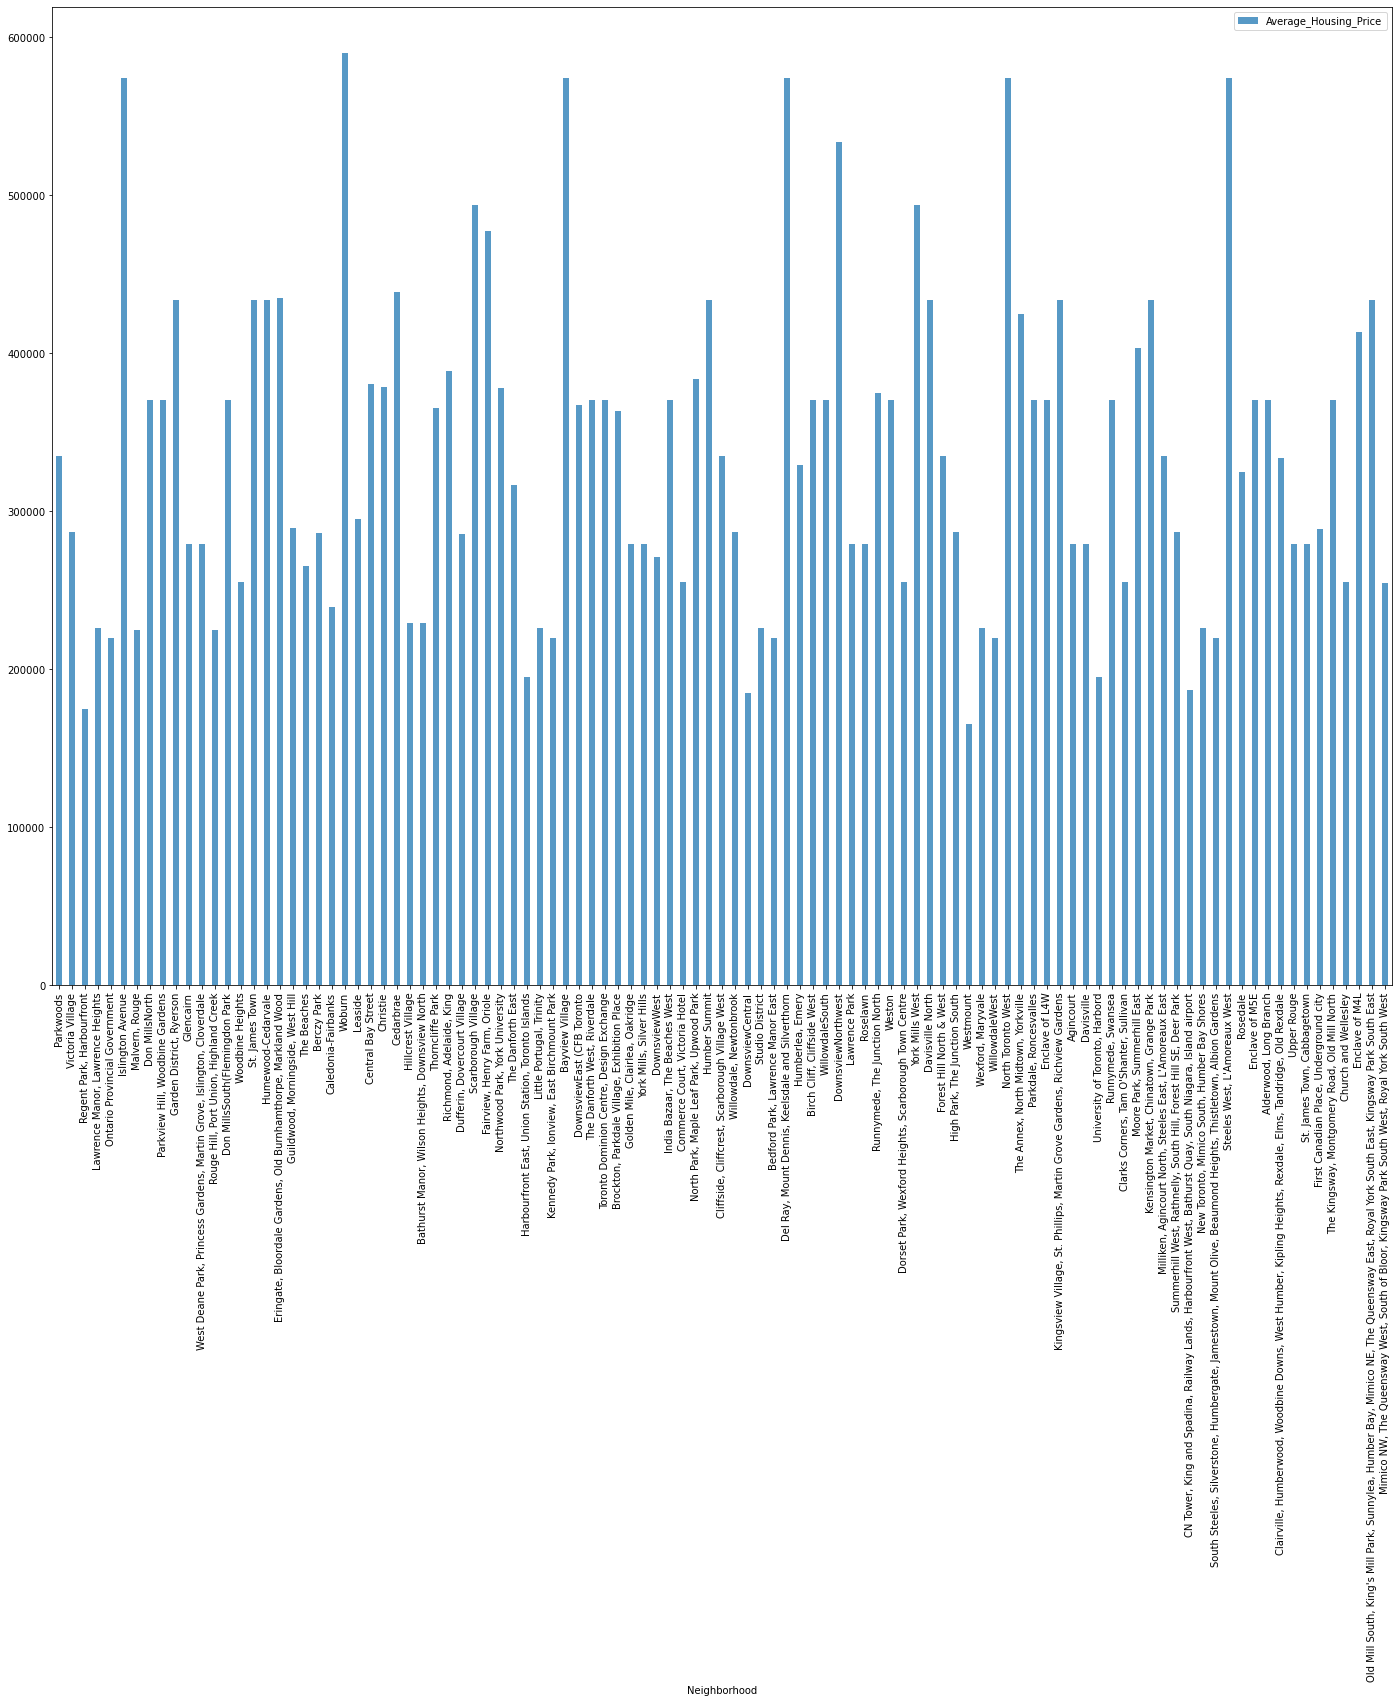

In [42]:
Scarborough_Avg_HousingPrice.plot(kind='bar',figsize=(24,18),alpha=0.75)

### School Rating by clusters

In [43]:

clusters=pd.DataFrame({"Cluster1":df1["Neighborhood"],
                      "Cluster2":df2["Neighborhood"],
                      "Cluster4":df3["Neighborhood"]})
clusters = clusters.replace(np.nan, '', regex=True)

In [45]:
new_Scarborough=Scarborough_merged.set_index("Neighborhood",drop=True)
#Source:https://www.greatschools.org
Scarborough_school_ratings=pd.DataFrame({"Neighborhood":dfToronto["Neighborhood"],
                                      "Top School Rating":[7,9,5,8,10,10,7,10,1,2,1,2,7,2,3,2,6,
                                                           5,4,8,9,9,6,6,4,5,4,6,8,10,8,9,6,2,
                                                           10,2,5,8,9,6,6,10,8,9,1,2,3,4,5,6,9,
                                                           8,5,9,6,9,6,4,8,10,2,5,6,3,9,8,7,
                                                           7,8,5,8,9,1,5,4,7,2,3,6,6,9,4,8,7,
                                                           4,8,9,2,6,4,7,5,10,4,6,8,9,7,5,6,5,8,7
                                                           ]})

In [46]:
Scarborough_school_ratings.set_index('Neighborhood',inplace=True,drop=True)

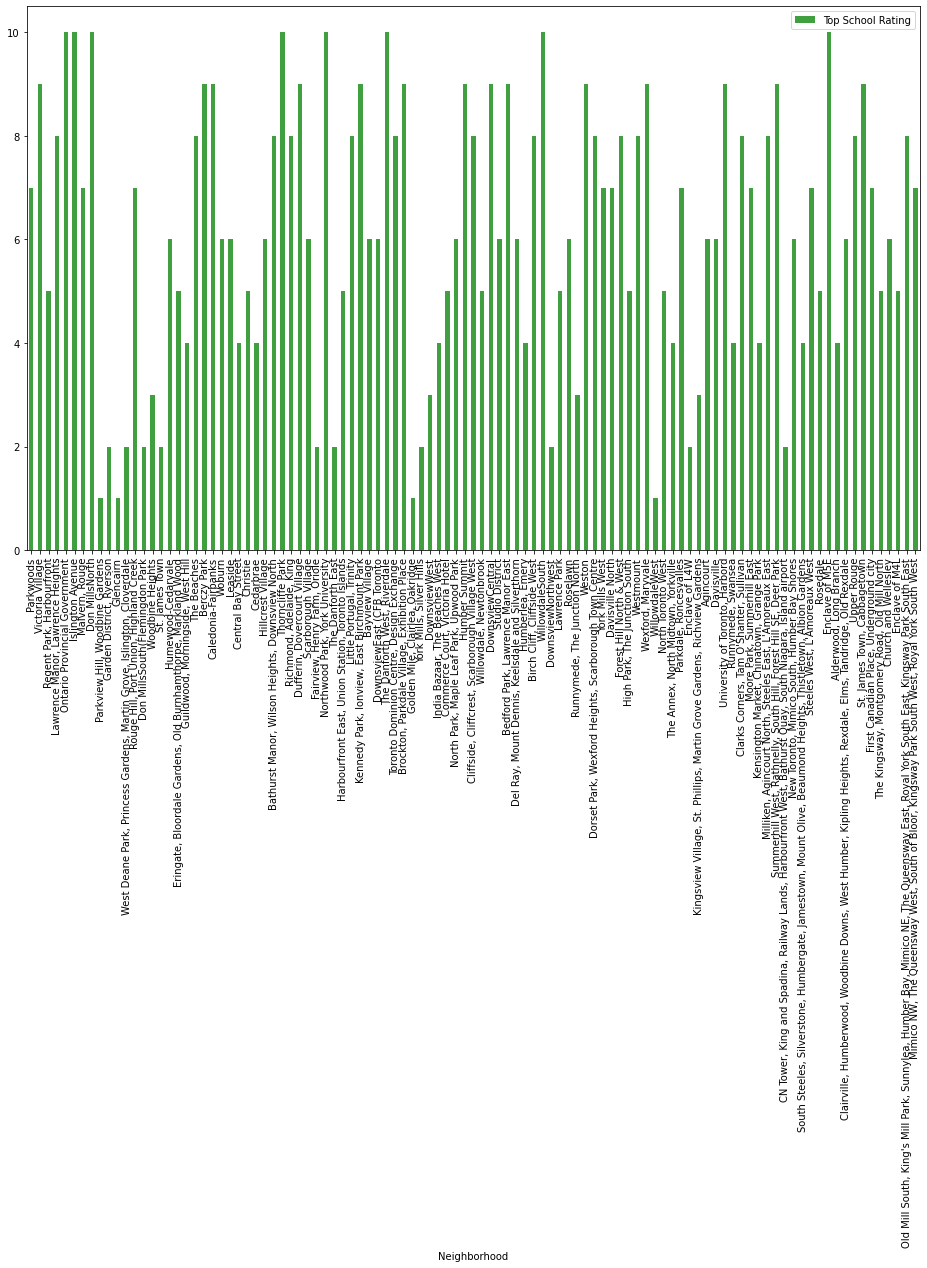

In [47]:
Scarborough_school_ratings.plot(kind='bar',figsize=(16,10),color='green',alpha=0.75);

Conclusion: Using k-means clustering I separated the neighborhoods into 10 different clusters and for 103 different lattitude+logitude from the dataset, which have very-similar neighborhoods around them. Using the charts above results presented to a particular neighborhood based on average house prices and school rating have been made.